# (Ford GoBike data exploration)
## by (Nahla Nabil)

## Investigation Overview

> In this Presentation, I'm most interested in figuring out features that affect using the bike-sharing system the most: 
- day of week
- the average trip time
- type of users
- user age
- user gender

## Dataset Overview

> Ford goBike dataset includes information about individual rides made in a bike-sharing system covering the greater San Francisco Bay area during Febraury 2019. It consists of info about trips taken by service's members, their types, their age, their gender, stations of starting and ending trips, duration of trips etc. There are 174,952 trips in the dataset with 21 features.

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [2]:
# load in the dataset into a pandas dataframe
df = pd.read_csv('fordgobike.csv')

In [3]:
df.dropna(subset = ['start_station_id', 'start_station_name', 'end_station_id', 'end_station_name', 'member_birth_year', 'member_gender'] ,inplace=True)

df['member_age'] = 2019 - df['member_birth_year']

df.start_time = pd.to_datetime(df.start_time)
df.end_time = pd.to_datetime(df.end_time)

df['duration_min'] = df['duration_sec']/60

In [4]:
df['start_day'] = df['start_time'].apply(lambda time: time.dayofweek)
week_day_dict = {
    0:'Monday',
    1:'Tuesday',
    2:'Wednesday',
    3:'Thursday',
    4:'Friday',
    5:'Saturday',
    6:'Sunday'}
df['start_day_week_day'] = df['start_day'].map(week_day_dict)

In [5]:
# approximate radius of earth in km
R = 6373.0
def disance_km_between_lon_lat(lat1, lon1, lat2, lon2):
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a ))
    return R * c

df['distance_km'] = disance_km_between_lon_lat(df['start_station_latitude'], df['start_station_longitude'], df['end_station_latitude'], df['end_station_longitude'])

In [6]:
df = df[(df.member_age < 70)]

df = df[(df.distance_km > 0)]
df = df[(df.distance_km < 400)]

#cut off less than 100 & more than 3000
df = df[(df.duration_sec > 100)]
df = df[(df.duration_sec < 3000)]

> Note that the above cells have been set as "Skip"-type slides. That means
that when the notebook is rendered as http slides, those cells won't show up.

## (Charts of User type & Gender)

> Users are divided into 2 types, they are Subscribers & Customers. Also, there are 3 registered genders which are Males, Females & others. Those are plotted into piechart with each type percentage.

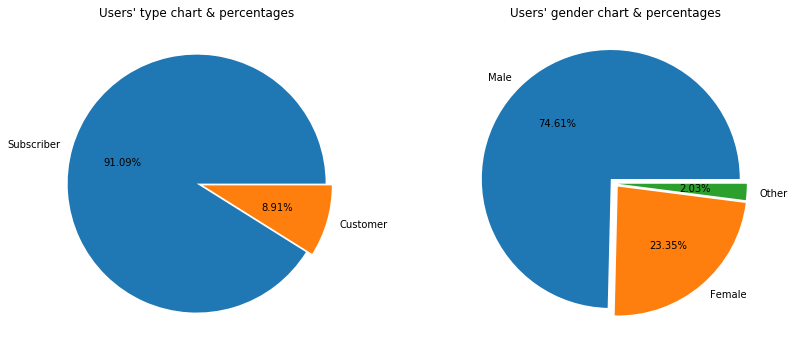

In [7]:
plt.subplot(1, 2, 1)
df.user_type.value_counts().plot.pie(figsize=(12,5), autopct='%.2f%%', explode=(0, .05))
plt.title("Users' type chart & percentages")
plt.ylabel('')

plt.subplot(1, 2, 2)
df.member_gender.value_counts().plot.pie(figsize=(12,5), autopct='%.2f%%', explode=(0.05, .03, 0.02))
plt.title("Users' gender chart & percentages")
plt.ylabel('')

plt.tight_layout()
plt.show()

- Users are divded into **Subscribers 90.86%** & **Customers 9.14%**
- Or divded into **Males 74.61%**, **Females 23.36%** & **Others 2.03%**

## (Number of rides for each day chart)

> Plotting distributkion of rides for all the week usage.

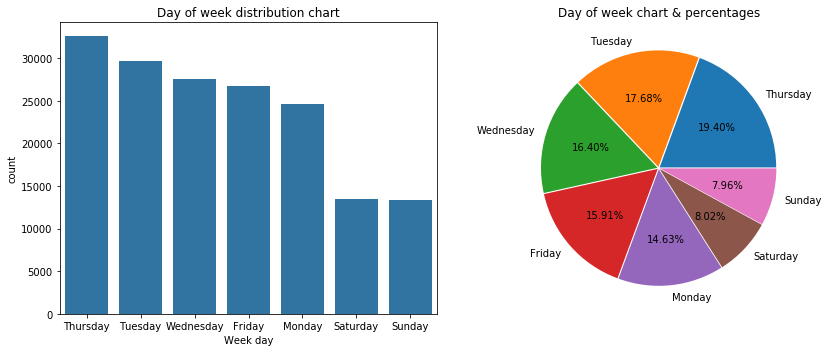

In [8]:
plt.subplot(1, 2, 1)
sb.countplot(data=df, x='start_day_week_day', color=sb.color_palette()[0], order=df['start_day_week_day'].value_counts().index)
plt.title("Day of week distribution chart")
plt.xlabel('Week day')

plt.subplot(1, 2, 2)
df.start_day_week_day.value_counts().plot.pie(figsize=(12,5), autopct='%.2f%%', explode=(0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01))
plt.title("Day of week chart & percentages")
plt.ylabel('')

plt.tight_layout()
plt.show()

According to start days, it's obvious that this system is used more during **weekdays** than **weekends**. By looking to the charts, we can see that days are ordered descending from most active days to least by the following percentages:
- Thursday: 19.34%
- Tuesday: 17.60%
- Wednesday: 16.33%
- Friday: 15.87%
- Monday: 14.64%
- Saturday: 8.13%
- Sunday: 8.10%

## (Distribution of duration in minutes)
> Plotting each trip duration & thier distribution


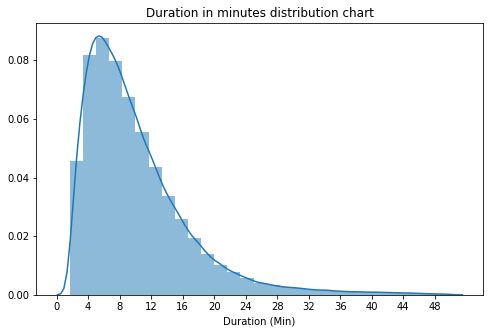

In [9]:
plt.figure(figsize = [8, 5]) 

bins = np.arange(0, df['duration_min'].max() + 10/6, 10/6)

sb.distplot(df['duration_min'], kde=True, bins =bins, hist_kws = {'alpha' : 0.5})

plt.xticks(np.arange(0, 51, step=4))
plt.xlabel('Duration (Min)')
plt.title('Duration in minutes distribution chart')

plt.show()

- By looking to the previous Histogram, it's obvious that duration in minutes is normally distributed. 
- We also can notice that values started to increase from 1 minute to almost 8 minutes then suddenly decreased. 
- We also may notice there's a high peak around 6 to 10 minutes.

## (Relation between Distance & Duration)
> Plotting relation between Distance in km & Duration in minutes

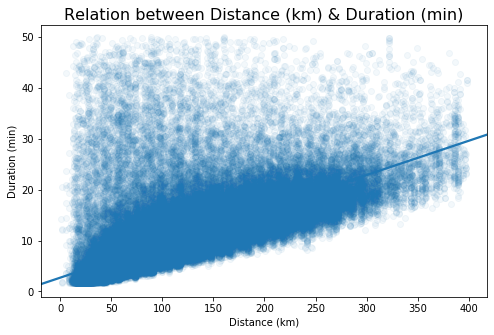

In [10]:
plt.figure(figsize = [8, 5])

sb.regplot(data = df, x = 'distance_km', y = 'duration_min', scatter_kws={'alpha':0.05})

plt.title('Relation between Distance (km) & Duration (min)', fontsize =16)
plt.xlabel('Distance (km)')
plt.ylabel('Duration (min)')

plt.show()

The regression line in a scatter plot showing a positive correlation between Distance (km) & Duration (min) , which make sense that long distances trips take more time.

## (Relation between Gender & Type)
> Plotting relation between each Gender & User's type

In [11]:
gt_counts = df.groupby(['member_gender', 'user_type']).size()
gt_counts = gt_counts.reset_index(name='count')
gt_counts = gt_counts.pivot(index = 'member_gender', columns = 'user_type', values = 'count')

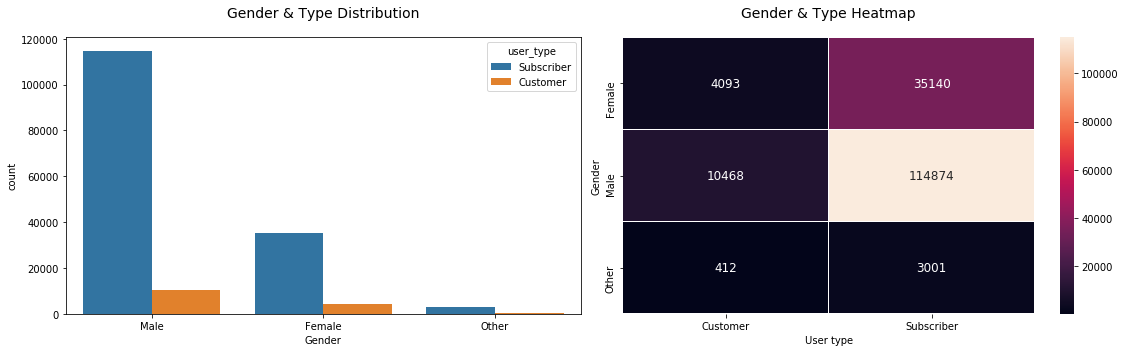

In [12]:
plt.figure(figsize = [16, 5])

# LEFT plot: violin plot
plt.subplot(1, 2, 1)

sb.countplot(data = df, x = 'member_gender', hue = 'user_type')

plt.title('Gender & Type Distribution', fontsize =14, pad=20)

plt.xlabel('Gender')


# RIGHT plot: box plot
plt.subplot(1, 2, 2)

sb.heatmap(gt_counts, annot=True, fmt="d", annot_kws={'size':12}, linewidths=.5)

plt.title('Gender & Type Heatmap', fontsize =14, pad=20)

plt.xlabel('User type')
plt.ylabel('Gender')

plt.tight_layout()

plt.show()

- From graphs, we can indicate that Subscribers are always larger than Customers for all 3 gender types.
- Most **Subscribers** are Males = 114874 **male-subscriber**, followed by 35140 **female-Subscriber**, then the least number of Subscribers are 3001 **other-subscriber**.
- For **Customers**, Most of them are Males = 10468 **male-customer**, then 4093 **female-customer** & the least are 412 **other-customer**

## (Weekly rides by user type & gender)
> Plotting distribution of rides of each user type & gender for all the week


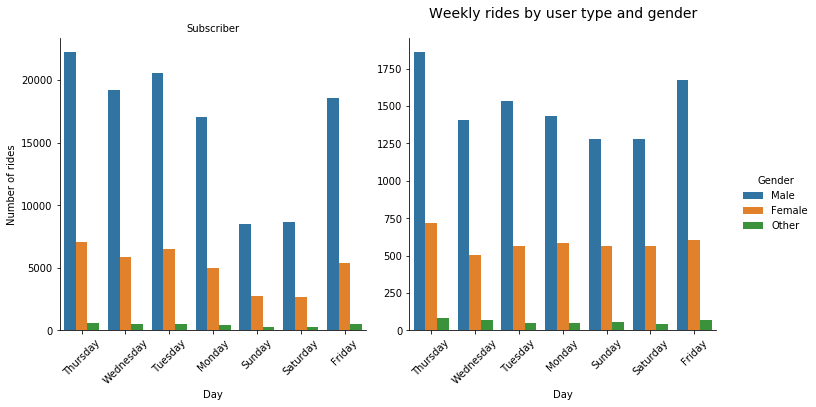

In [13]:
g = sb.catplot(data=df, x='start_day_week_day', col="user_type", hue="member_gender", kind='count', sharey = False)
g.set_axis_labels("Day", "Number of rides")

g._legend.set_title('Gender')
g.set_titles("{col_name}")

plt.title('Weekly rides by user type and gender', fontsize=14, pad=20)

for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)

plt.show()

- Number of rides for both **Male-Customers** & **Male-Subscribers** increases during weekdays but are less during weekends.
- Number of rides for **Female-Subscribers** also increases during weekdayse but decreases during weekends.
- **Female-Subscribers** are less than **Males**, with large difference.
- **Female-Customers** just increases in **Thursday**, while decreases & almost still the same the whole week.
- **Others-Subscribers** increases during weekdays & decreases during weekends.
- **Others-Customers** increases in **Thursdays, Wednesdays & Fridays**, but decreases and still the same for **Tuesdays, Mondays, Sundays & Saturdays**.

## Key Insights
> I focused on Member gender, User type, Start day, Duration & distance and their relations with each others.
> We can find that:
- User type Subscribers are more than Customers
- Most members ages are between 27:33 years
- Most registered ride duration in the system are almost 10 minutes
- Rides during weekdays are more than weekends
- There is positive correlation between duration & distance
- Males are more than Females & the useres signed with gender others are the least